In [22]:
%matplotlib inline
import math
import random
import numpy as np
import pandas as pd
import itertools
import scipy.stats as stats
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.stats.stats import pearsonr

from sklearn import tree
from sklearn import metrics
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import train_test_split
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score

import pydotplus 
from IPython.display import Image

In [2]:
df = pd.read_csv("../HR_comma_sep.csv")

In [3]:
def categorical_to_numerical(df):
    
    # Get the unique values of role
    roles = sorted(df['sales'].unique())
    
    # Generate a mapping of role from a string to a number representation    
    roles_mapping = dict(zip(roles, range(0, len(roles) + 1)))

    # Transform roles from a string to a number representation
    df['sales'] = df['sales'].map(roles_mapping).astype(int)
    
    # Get the unique values of salary
    salaries = sorted(df['salary'].unique())

    # Generate a mapping of salary from a string to a number representation        
    salaries_mapping = dict(zip(salaries, range(0, len(salaries) + 1)))
    
    # Transform salary from a string to a number representation
    df['salary'] = df['salary'].map(salaries_mapping).astype(int)
    
    # Drop the columns we won't use:
    df = df.drop(['promotion_last_5years'], axis=1)
    
    return df

In [4]:
df = categorical_to_numerical(df)

In [5]:
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,sales,salary
0,0.38,0.53,2,157,3,0,1,7,1
1,0.80,0.86,5,262,6,0,1,7,2
2,0.11,0.88,7,272,4,0,1,7,2
3,0.72,0.87,5,223,5,0,1,7,1
4,0.37,0.52,2,159,3,0,1,7,1


In [6]:
# Convert the DataFrame to a numpy array:
data_array = df.values

In [7]:
# Training data features, skip the column 'left'
train_features = data_array[:, [0, 1, 2, 3, 4, 5, 7, 8]]

# 'left' column values
train_target = data_array[:, 6]

In [8]:
# Train-test partitioning, 70% and 30% respectively
# (stratified sampling by default).

# train_x = features of the training set
# train_y = target output for the training set

# test_x = features of the test set
# test_y = target output for the test set

train_x, test_x, train_y, test_y = train_test_split(train_features, 
                                                    train_target, 
                                                    test_size=0.30, 
                                                    random_state=0)

In [9]:
from sklearn.model_selection import cross_validate

In [24]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [25]:
def print_model_scores(clf):
    # Assuming the caller has already executed the 'fit' method
    print 'Model parameters:' 
    print '\t criterion -> %s' % (clf.criterion)
    print '\t max_depth -> %s' % clf.max_depth 
    print '\t min_samples_split -> %d' % clf.min_samples_split 
    print '\t min_samples_leaf -> %d' % clf.min_samples_leaf 
    print '\t class_weight -> %s' % clf.class_weight
    
    # Prediction on training set
    predicted_train_val = clf.predict(train_x)
    print 'Train scores:'
    print '\t precision: %0.3f' % metrics.precision_score(train_y, predicted_train_val, average='weighted')
    print '\t recall: %0.3f' % metrics.recall_score(train_y, predicted_train_val, average='weighted')
    print '\t f1: %0.3f' % metrics.f1_score(train_y, predicted_train_val, average='weighted')
    print '\t accuracy: %0.3f' % metrics.accuracy_score(train_y, predicted_train_val)
    
    # Prediction on test set
    predicted_test_val = clf.predict(test_x)
    print 'Test scores:'
    print '\t precision: %0.3f' % metrics.precision_score(test_y, predicted_test_val, average='weighted')
    print '\t recall: %0.3f' % metrics.recall_score(test_y, predicted_test_val, average='weighted')
    print '\t f1: %0.3f' % metrics.f1_score(test_y, predicted_test_val, average='weighted')
    print '\t accuracy: %0.3f' % metrics.accuracy_score(test_y, predicted_test_val)
    
    plt.figure()
    plot_confusion_matrix(confusion_matrix(test_y,predicted_test_val),
                          ['not_left', 'left'],
                          )


In [11]:
def print_model_scores_with_cross_validation(clf):
    scorings = ['precision_macro', 'recall_macro', 'f1_macro', 'accuracy']
    scores = cross_validate(clf, train_features, train_target, cv=10, 
                            return_train_score=True,
                            scoring = scorings)
    print 'Model parameters:' 
    print '\tcriterion -> %s' % (clf.criterion)
    print '\tmax_depth -> %s' % clf.max_depth 
    print '\tmin_samples_split -> %d' % clf.min_samples_split 
    print '\tmin_samples_leaf -> %d' % clf.min_samples_leaf 
    print '\tclass_weight -> %s' % clf.class_weight
    
    print 'Train scores:'
    print '\tPrecision -> %0.2f (+/- %0.2f)' % (scores['train_precision_macro'].mean(), scores['train_precision_macro'].std() * 2)
    print '\tRecall -> %0.2f (+/- %0.2f)' % (scores['train_recall_macro'].mean(), scores['train_recall_macro'].std() * 2)
    print '\tf1 -> %0.2f (+/- %0.2f)' % (scores['train_f1_macro'].mean(), scores['train_f1_macro'].std() * 2)
    print '\tAccuracy -> %0.2f (+/- %0.2f)' % (scores['train_accuracy'].mean(), scores['train_accuracy'].std() * 2)

    print 'Test scores:'
    print '\tPrecision -> %0.2f (+/- %0.2f)' % (scores['test_precision_macro'].mean(), scores['test_precision_macro'].std() * 2)
    print '\tRecall -> %0.2f (+/- %0.2f)' % (scores['test_recall_macro'].mean(), scores['test_recall_macro'].std() * 2)
    print '\tf1 -> %0.2f (+/- %0.2f)' % (scores['test_f1_macro'].mean(), scores['test_f1_macro'].std() * 2)
    print '\tAccuracy -> %0.2f (+/- %0.2f)' % (scores['test_accuracy'].mean(), scores['test_accuracy'].std() * 2)

In [12]:
def get_tree(clf):  
    dot_data = tree.export_graphviz(clf, out_file=None, 
                             feature_names=list(df.columns[[0, 1, 2, 3, 4, 5, 7, 8]]),  
                             class_names=['Not left', 'Left'], 
                             filled=True, rounded=True,  
                             special_characters=True,
                             max_depth=2) # print only up to 3 levels
    graph = pydotplus.graph_from_dot_data(dot_data)  
    #Image(graph.create_png())
    return graph

Model parameters:
	 criterion -> gini
	 max_depth -> None
	 min_samples_split -> 10
	 min_samples_leaf -> 10
	 class_weight -> {0: 1, 1: 4}
Train scores:
	 precision: 0.973
	 recall: 0.971
	 f1: 0.972
	 accuracy: 0.971
Test scores:
	 precision: 0.961
	 recall: 0.959
	 f1: 0.960
	 accuracy: 0.959
Confusion matrix, without normalization
[[3327  135]
 [  48  990]]


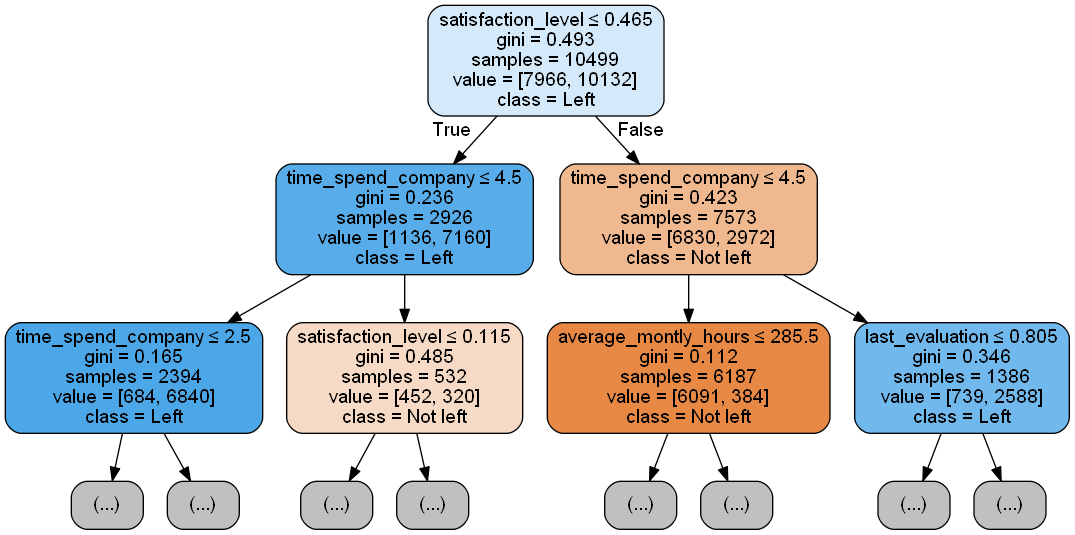

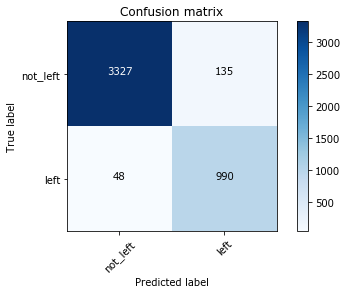

In [26]:
clf = tree.DecisionTreeClassifier(criterion='gini', 
                                  splitter='best', 
                                  # If max_depth = None, then nodes are expanded until all leaves are pure or 
                                  # until all leaves contain less than 'min_samples_split' samples
                                  max_depth=None, 
                                  # The minimum number of samples required to split an internal node
                                  min_samples_split=10,
                                  # The minimum number of samples required to be at a leaf node
                                  min_samples_leaf=10,
                                  # Weight of classes: 'Not left' = 1, 'Left = 4'
                                  # (rows with left == 1 are around 25%)
                                  class_weight = {0:1, 1:4})
#print_model_scores_with_cross_validation(clf)

# Train the model on the training set
clf.fit(train_x, train_y)

# Print the performances both on training and test set
print_model_scores(clf)

img = get_tree(clf)
Image(img.create_png())

Model parameters:
	 criterion -> gini
	 max_depth -> 2
	 min_samples_split -> 2
	 min_samples_leaf -> 2
	 class_weight -> None
Train scores:
	 precision: 0.851
	 recall: 0.847
	 f1: 0.826
	 accuracy: 0.847
Test scores:
	 precision: 0.861
	 recall: 0.857
	 f1: 0.838
	 accuracy: 0.857
Confusion matrix, without normalization
[[3403   59]
 [ 584  454]]


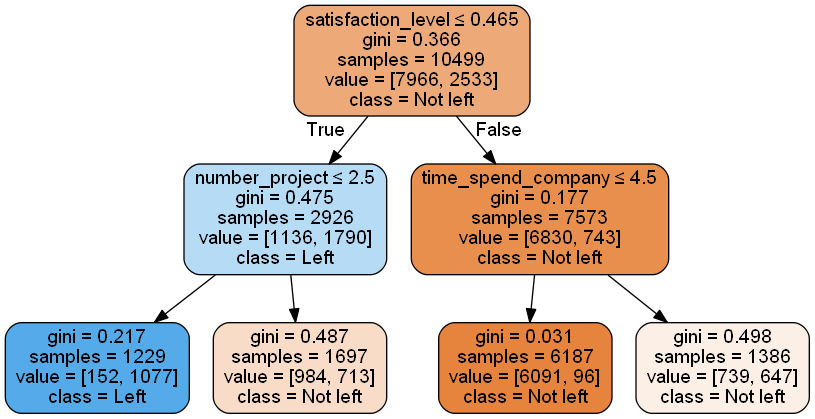

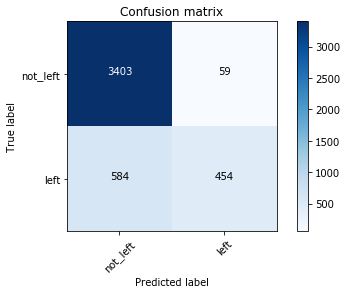

In [27]:
clf = tree.DecisionTreeClassifier(criterion='gini', 
                                  splitter='best', 
                                  # If max_depth = None, then nodes are expanded until all leaves are pure or 
                                  # until all leaves contain less than 'min_samples_split' samples
                                  max_depth=2, 
                                  # The minimum number of samples required to split an internal node
                                  min_samples_split=2,
                                  # The minimum number of samples required to be at a leaf node
                                  min_samples_leaf=2)
# print_model_scores_with_cross_validation(clf)

clf.fit(train_x, train_y)

print_model_scores(clf)

img = get_tree(clf)
Image(img.create_png())

Model parameters:
	 criterion -> entropy
	 max_depth -> 3
	 min_samples_split -> 10
	 min_samples_leaf -> 10
	 class_weight -> {0: 1, 1: 4}
Train scores:
	 precision: 0.926
	 recall: 0.914
	 f1: 0.917
	 accuracy: 0.914
Test scores:
	 precision: 0.922
	 recall: 0.908
	 f1: 0.911
	 accuracy: 0.908
Confusion matrix, without normalization
[[3117  345]
 [  70  968]]


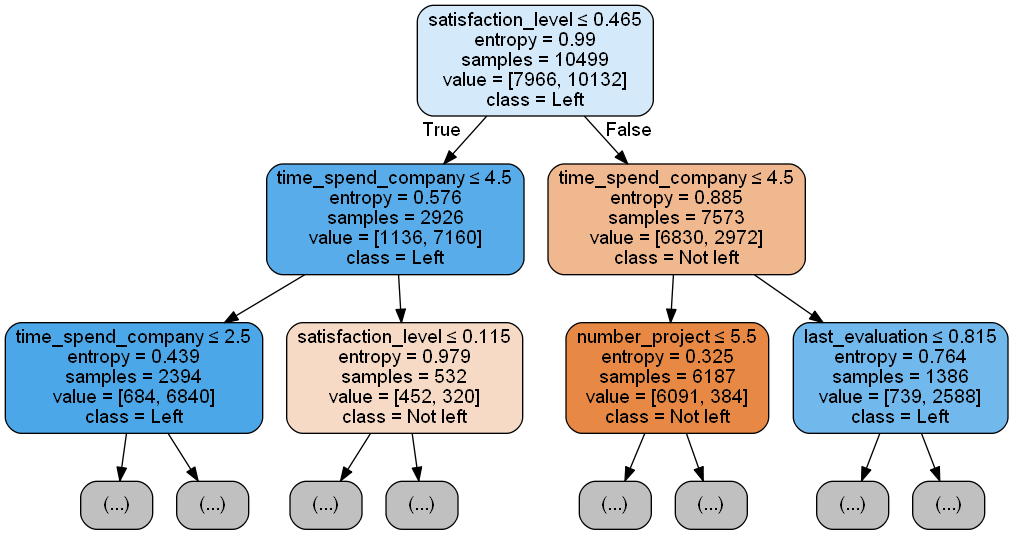

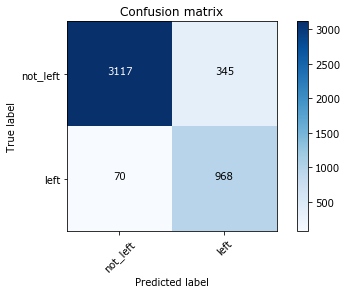

In [28]:
clf = tree.DecisionTreeClassifier(criterion='entropy', 
                                  splitter='best', 
                                  # If max_depth = None, then nodes are expanded until all leaves are pure or 
                                  # until all leaves contain less than 'min_samples_split' samples
                                  max_depth=3, 
                                  # The minimum number of samples required to split an internal node
                                  min_samples_split=10,
                                  # The minimum number of samples required to be at a leaf node
                                  min_samples_leaf=10,
                                  # Weight of classes: 'Not left' = 1, 'Left = 4'
                                  # (rows with left == 1 are around 25%)
                                  class_weight = {0:1, 1:4})
# print_model_scores_with_cross_validation(clf)
clf.fit(train_x, train_y)
print_model_scores(clf)
img = get_tree(clf)
Image(img.create_png())

Model parameters:
	 criterion -> entropy
	 max_depth -> None
	 min_samples_split -> 200
	 min_samples_leaf -> 2000
	 class_weight -> {0: 1, 1: 4}
Train scores:
	 precision: 0.864
	 recall: 0.726
	 f1: 0.745
	 accuracy: 0.726
Test scores:
	 precision: 0.868
	 recall: 0.723
	 f1: 0.745
	 accuracy: 0.723
Confusion matrix, without normalization
[[2235 1227]
 [  18 1020]]


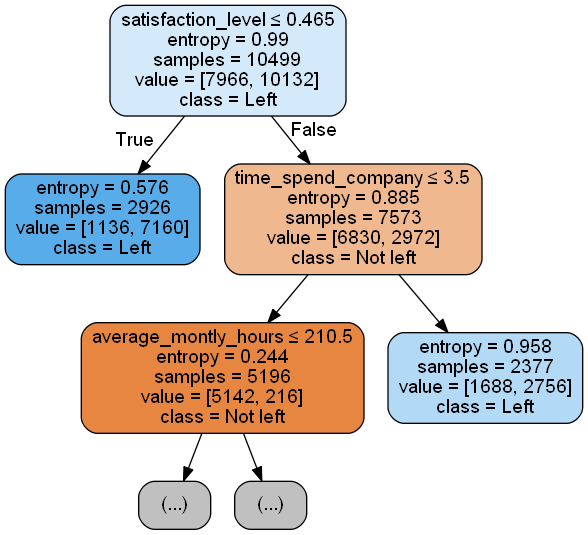

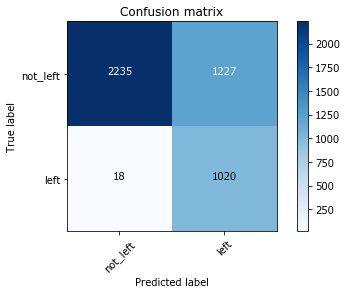

In [29]:
clf = tree.DecisionTreeClassifier(criterion='entropy', 
                                  splitter='best', 
                                  # If max_depth = None, then nodes are expanded until all leaves are pure or 
                                  # until all leaves contain less than 'min_samples_split' samples
                                  max_depth=None, 
                                  # The minimum number of samples required to split an internal node
                                  min_samples_split=200,
                                  # The minimum number of samples required to be at a leaf node
                                  min_samples_leaf=2000,
                                  class_weight = {0:1, 1:4})
# print_model_scores_with_cross_validation(clf)
clf.fit(train_x, train_y)
print_model_scores(clf)
img = get_tree(clf)
Image(img.create_png())

In [40]:
# Random Forest: static parameter initialization

clf = RandomForestClassifier(n_estimators=30, 
                             criterion='gini',
                             max_features=None,
                             max_depth=None, 
                             min_samples_split=2,
                             min_samples_leaf=5,
                             bootstrap=True,
                             oob_score=False,
                             random_state=None,
                             class_weight=None) # classes are considered balanced

# Performs a 10-fold cross validation on the training set. We are
# passing the whole dataset as training set, but cross validation
# performs 10 possible splittings of train/test.
scores = cross_validation.cross_val_score(clf, train_features, train_target, cv=10)
print 'Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2)

Accuracy: 0.98 (+/- 0.01)


In [15]:
from scipy.stats import randint as sp_randint

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

In [16]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [19]:
clf = RandomForestClassifier(n_estimators=20)

# Set up a grid of parameters for the RandomForestClassifier, then randomly
# pick 100 combinations of the possible parameters and finally report the 
# best 3 models you've found. 
param_dist = {
              # If max_depth = None, then nodes are expanded until all leaves are pure or 
              # until all leaves contain less than 'min_samples_split' samples
              "max_depth": [2,3,4,5,6,7,8,9,10,11,12,None],
              "max_features": sp_randint(1, len(train_x[0]) + 1),
              # The minimum number of samples required to split an internal node
              "min_samples_split": sp_randint(10, 51),
              # The minimum number of samples required to be at a leaf node
              "min_samples_leaf": sp_randint(10, 51),
              "bootstrap": [True],
              "criterion": ["entropy", "gini"],
              "class_weight":['balanced', None, {0: 0.3, 1: 0.7}]}

n_iter_search = 100
search = RandomizedSearchCV(clf, param_distributions=param_dist, 
                            n_iter=n_iter_search, 
                            n_jobs=-1, # use all the cores 
                            scoring=make_scorer(accuracy_score))

In [23]:
# Run all the 100 combinations and report the best 3 models,
# along with the parameters they used.
search.fit(train_features, train_target)

print_model_scores(search.best_estimator_.estimators_[0])

'''
scores = cross_validation.cross_val_score(search, train_x, train_y, cv=10)
print 'Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2)
report(search.cv_results_, 3) 
'''

Model parameters:
	 criterion -> entropy
	 max_depth -> 11
	 min_samples_split -> 10
	 min_samples_leaf -> 10
	 class_weight -> None
Train scores:
	 precision: 0.975
	 recall: 0.975
	 f1: 0.975
	 accuracy: 0.975
Test scores:
	 precision: 0.975
	 recall: 0.975
	 f1: 0.975
	 accuracy: 0.975


"\nscores = cross_validation.cross_val_score(search, train_x, train_y, cv=10)\nprint 'Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2)\nreport(search.cv_results_, 3) \n"

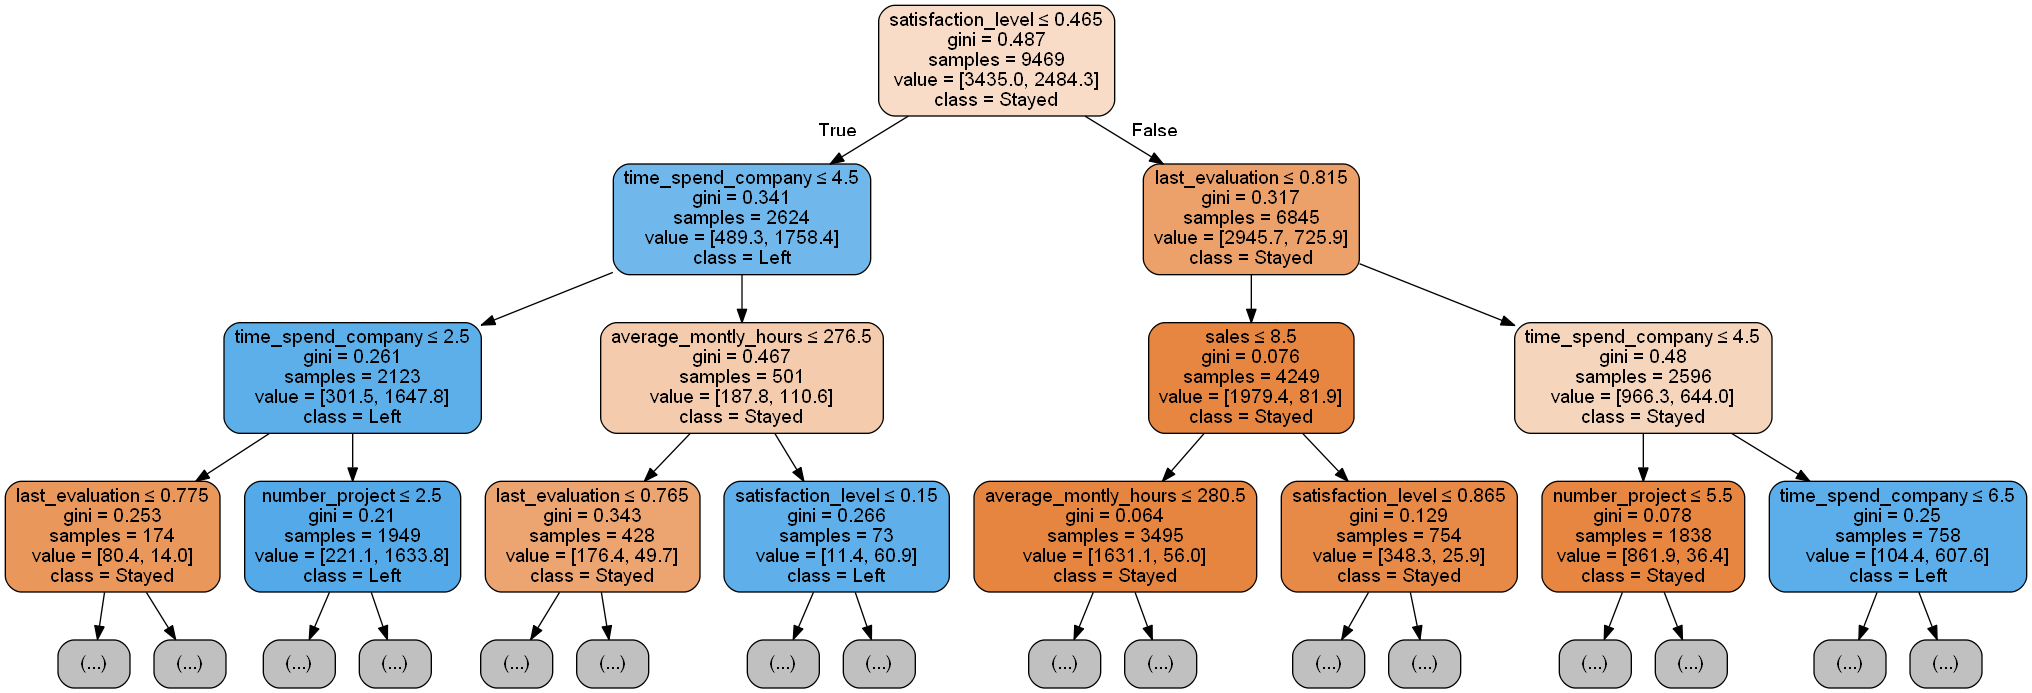

In [22]:
# Print the shape of the best tree
import pydotplus 
from IPython.display import Image  
dot_data = tree.export_graphviz(search.best_estimator_.estimators_[0], out_file=None, 
                         feature_names=list(df.columns[[0, 1, 2, 3, 4, 5, 7, 8]]),  
                         class_names=['Stayed', 'Left'], 
                         filled=True, rounded=True,  
                         special_characters=True,
                         max_depth=3) # print only up to 3 levels
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())